In [1]:
import torch.nn as nn
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import os
import math

# summary

    https://www.cnblogs.com/skyfsm/p/6806246.html 基于深度学习的目标检测技术演进：R-CNN、Fast R-CNN、Faster R-CNN
    
    https://blog.csdn.net/u013293750/article/details/64904681 CNN+LSTM深度学习文字检测
    
    https://blog.csdn.net/forest_world/article/details/78566737 主流ocr算法：CNN+BLSTM+CTC架构
    
    https://blog.csdn.net/slade_ruan/article/details/78301842?utm_source=blogxgwz1 场景文本检测，CTPN tensorflow版本
    
    https://blog.csdn.net/Quincuntial/article/details/79475339?utm_source=blogxgwz1 CTPN论文翻译——中英文对照
    
    http://lib.csdn.net/article/deeplearning/61632  通过代码理解faster-RCNN中的RPN
    
    https://slade-ruan.me/2017/10/22/text-detection-ctpn/  论文阅读与实现--CTPN

    https://www.cnblogs.com/freeweb/p/6548208.html

    https://deepsense.ai/region-of-interest-pooling-in-tensorflow-example/

    https://www.cnblogs.com/king-lps/p/9031568.html

# create data

In [ ]:
# 生成训练、测试数据

# data ready

In [2]:
from lib.datasets.factory import get_imdb
from lib.datasets.pascal_voc import pascal_voc
from lib.roi_data_layer.roidb import prepare_roidb
from lib.roi_data_layer.layer import RoIDataLayer


imdb = pascal_voc('trainval', '2007')
# roidb ROI框的坐标位置信息, 信息来源于Annotations目录下对图片的XML定义
prepare_roidb(imdb)   #  为方便训练，在原roidb信息基础上增加象image等等信息
roidb = imdb.roidb 
data_layer = RoIDataLayer(roidb, imdb.num_classes)

voc_2007_train
voc_2007_val
voc_2007_trainval
voc_2007_test
<bound method imdb.default_roidb of <lib.datasets.pascal_voc.pascal_voc object at 0x000001B32F5BF2B0>>
voc_2007_trainval gt roidb loaded from D:\PROJECT_TW\git\data\voc_2007_trainval_gt_roidb.pkl


# model

In [3]:
RPN_CHANNELS = 512
TRUNCATED = False
class DataMul(nn.Module):
    def __init__(self, in_size, out_dim, bias= True):
        super(DataMul, self).__init__()
        self.in_size = in_size
        self.out_dim = out_dim
        self.weight = torch.nn.Parameter(torch.Tensor(in_size, out_dim))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)    
    
    def forward(self, input):
        out = input.matmul(self.weight) + self.bias
        return out
    
    def extra_repr(self):
        return 'in_size={}, out_dim={}, bias={}'.format(
            self.in_size, self.out_dim, self.bias)   
    
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self._predictions = {}
        self._losses = {}
        self._anchor_targets = {}
        self._proposal_targets = {}
        self._layers = {}
        self._gt_image = None
        self._act_summaries = {}
        self._score_summaries = {}
        self._event_summaries = {}
        self._image_gt_summaries = {}
        self._variables_to_fix = {}

    def create_architecture(self, num_classes, tag=None,anchor_scales=(16,), anchor_ratios=(0.5, 1, 2)):
        self._tag = tag
        self._num_classes = num_classes
        self._anchor_scales = anchor_scales
        self._num_scales = len(anchor_scales)
        self._anchor_ratios = anchor_ratios
        self._num_ratios = len(anchor_ratios)
        self._num_anchors = 10
        assert tag != None
        # Initialize layers
        self._init_modules()
        
    def _init_modules(self):
        self._init_head_tail()
        # rpn
        self.rpn_net = nn.Conv2d(self._net_conv_channels, RPN_CHANNELS, [3, 3], padding=1)
        self.rpn_bi_net = nn.LSTM(RPN_CHANNELS, 256, batch_first=True, bidirectional=True)
#         self.rpn_cls_score_net = nn.LSTM(RPN_CHANNELS, self._num_anchors * 2, batch_first=True, bidirectional=False)
#         self.rpn_bbox_pred_net = nn.LSTM(RPN_CHANNELS, self._num_anchors * 4, batch_first=True, bidirectional=False)
        self.rpn_cls_score_net = DataMul(RPN_CHANNELS, self._num_anchors * 2)
        self.rpn_bbox_pred_net = DataMul(RPN_CHANNELS, self._num_anchors * 4)
        self.init_weights()    
        
    # 对构建的网络参数（weight, bias）进行正则、初始化
    def init_weights(self):
        def normal_init(m, mean, stddev, truncated=False):
            """
                weight initalizer: truncated normal and random normal.
            """
            # x is a parameter
            if isinstance(m, nn.LSTM):
                init.xavier_normal_(m.all_weights[0][0])
                init.xavier_normal_(m.all_weights[0][1])
                if len(m.all_weights) == 2:   # 双向  LSTM
                    init.xavier_normal_(m.all_weights[1][0])
                    init.xavier_normal_(m.all_weights[1][1])
            else:
                if truncated:
                    m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
                else:
                    m.weight.data.normal_(mean, stddev)
                m.bias.data.zero_()
        normal_init(self.rpn_net, 0, 0.01, TRUNCATED)
#         normal_init(self.rpn_cls_score_net,0, 0.01, TRUNCATED)
#         normal_init(self.rpn_bbox_pred_net,0, 0.01, TRUNCATED)
        normal_init(self.rpn_bi_net,0, 0.01, TRUNCATED)
        

In [4]:
class vgg16(Network):
    def __init__(self):
        Network.__init__(self)
        self._feat_stride = [16, ]
        self._feat_compress = [1. / float(self._feat_stride[0]), ]
        self._net_conv_channels = 512
        self._fc7_channels = 4096

    def _init_head_tail(self):
        # 注意， 通过 models.vgg16() 加载的模型是基础模型，是还没有经过训练的模型， 所以需要load_pretrained_cnn从外部载入已训练好的权重信息
        # 而通过 models.vgg16(pretrained=True)，则是已训练好的模型，无需再加载模型，本次实现采用models.vgg16(pretrained=True)，无需再加载了
        # 注意预加载的是识别图像的（对于识字的需做更改）
        self.vgg = models.vgg16_bn(pretrained=True)
        # Remove fc8
        self.vgg.classifier = nn.Sequential(*list(self.vgg.classifier._modules.values())[:-1])

        # Fix the layers before conv3:
        for layer in range(12):
            for p in self.vgg.features[layer].parameters(): 
                p.requires_grad = False

        # not using the last maxpool layer
        self._layers['head'] = nn.Sequential(*list(self.vgg.features._modules.values())[:-1])
#         print(self._layers['head'])


    # 通过卷积网络VG16的feature层，抽取图片的特征
    def _image_to_head(self):
        net_conv = self._layers['head'](self._image)
        self._act_summaries['conv'] = net_conv
        return net_conv

    def _head_to_tail(self, pool5):
        pool5_flat = pool5.view(pool5.size(0), -1)
        fc7 = self.vgg.classifier(pool5_flat)
        return fc7


    # 注意， 通过 models.vgg16() 加载的模型是基础模型，是还没有经过训练的模型， 所以需要该方法从外部载入权重信息
    # 而通过 models.vgg16(pretrained=True)，则是已训练好的模型，无需再加载模型，本次实现采用models.vgg16(pretrained=True)，
    # 无需再加载了
    def load_pretrained_cnn(self, state_dict):
        self.vgg.load_state_dict({k:v for k,v in state_dict.items() if k in self.vgg.state_dict()})


# train

In [5]:
# https://blog.csdn.net/garfielder007/article/details/51378296  Python numpy函数hstack() vstack() stack() dstack() vsplit() concatenate()
from lib.layutils.generate_anchors import generate_anchors
import lib.layutils.anchor_target_layer as atl
import numpy as np
DEBUG_IN = False
def generate_anchors_pre(height, width, feat_stride, anchor_scales=(8,16,32), anchor_ratios=(0.5,1,2)):
    """ A wrapper function to generate anchors given different scales
    Also return the number of anchors in variable 'length'
    """
    anchors = generate_anchors(ratios=np.array(anchor_ratios), scales=np.array(anchor_scales))
    A = anchors.shape[0]
    shift_x = np.arange(0, width) * feat_stride
    shift_y = np.arange(0, height) * feat_stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()
    K = shifts.shape[0]
    # width changes faster, so here it is H, W, C
    anchors = anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2))
    anchors = anchors.reshape((K * A, 4)).astype(np.float32, copy=False)
    length = np.int32(anchors.shape[0])
    return anchors, length

def _anchor_target_layer(rpn_cls_score, gt_boxes, im_info, feat_stride, anchors, num_anchors):
#     print('_anchor_target_layer begin .... 开始 。。。。')
    rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights = atl.anchor_target_layer(
        rpn_cls_score.data,
        gt_boxes.data.numpy(),
        im_info,
        feat_stride,
        anchors.data.numpy(),
        num_anchors)

    rpn_labels = torch.from_numpy(rpn_labels).float() #.set_shape([1, 1, None, None])
    rpn_bbox_targets = torch.from_numpy(rpn_bbox_targets).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_bbox_inside_weights = torch.from_numpy(rpn_bbox_inside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_bbox_outside_weights = torch.from_numpy(rpn_bbox_outside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_labels = rpn_labels.long()
#     self._anchor_targets['rpn_labels'] = rpn_labels
#     self._anchor_targets['rpn_bbox_targets'] = rpn_bbox_targets
#     self._anchor_targets['rpn_bbox_inside_weights'] = rpn_bbox_inside_weights
#     self._anchor_targets['rpn_bbox_outside_weights'] = rpn_bbox_outside_weights
#     for k in self._anchor_targets.keys():
#         self._score_summaries[k] = self._anchor_targets[k]
    

    return rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights


def _smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0, dim=[1]):
    sigma_2 = sigma ** 2
    box_diff = bbox_pred - bbox_targets
    in_box_diff = bbox_inside_weights * box_diff
    abs_in_box_diff = torch.abs(in_box_diff)
    smoothL1_sign = (abs_in_box_diff < 1. / sigma_2).detach().float()
    in_loss_box = torch.pow(in_box_diff, 2) * (sigma_2 / 2.) * smoothL1_sign \
                  + (abs_in_box_diff - (0.5 / sigma_2)) * (1. - smoothL1_sign)
    out_loss_box = bbox_outside_weights * in_loss_box
    loss_box = out_loss_box
    for i in sorted(dim, reverse=True):
        loss_box = loss_box.sum(i)
    loss_box = loss_box.mean()
    return loss_box

def _add_loss(rpn_cls_score_reshape,rpn_labels,
              rpn_bbox_pred,
              rpn_bbox_targets,
              rpn_bbox_inside_weights,
              rpn_bbox_outside_weights,
             sigma_rpn = 3.0):
#     loss_fun = nn.MSELoss() 
    rpn_cls_score = rpn_cls_score_reshape.view(-1,2)
#     print('rpn cls score --> \n {}'.format(rpn_cls_score))
#     rpn_cls_score = rpn_cls_score_reshape
    rpn_label = rpn_labels.view(-1)
    rpn_select = (rpn_label.data != -1).nonzero().view(-1)
    rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
    rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
#     rpn_label = rpn_label.unsqueeze(1)
#     print('rpn labels --> \n {}'.format(rpn_label))
    if DEBUG_IN:
        print('rpn cls score --> \n {}'.format(rpn_cls_score))
        print('rpn label --> \n {}'.format(rpn_label))
    rpn_cross_entropy = F.cross_entropy(rpn_cls_score, rpn_label)
    
    rpn_loss_box = _smooth_l1_loss(rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights,
                                          rpn_bbox_outside_weights, sigma=sigma_rpn, dim=[1, 2, 3])
    
    loss = rpn_cross_entropy + rpn_loss_box
#     loss = rpn_cross_entropy
    return loss,rpn_cross_entropy,rpn_loss_box


In [6]:
DEBUG = False
# feat_stride：[16]VGG中conv5_3相比于输入图像缩小了16倍，也就是相邻两个点之间的stride=16 
feat_stride = [16, ]
ANCHOR_SCALES = [16]
ANCHOR_RATIOS = [0.5,1,2]
MOMENTUM = 0.9
lr = 0.001
DOUBLE_BIAS = True
BIAS_DECAY = False
WEIGHT_DECAY = 0.0005
EPCHO = 5000
num_anchors = 10
RPN_CHANNELS = 512

net = vgg16()
# print(imdb.num_classes)

net.create_architecture(imdb.num_classes, tag='default',
                                            anchor_scales=ANCHOR_SCALES,
                                            anchor_ratios=ANCHOR_RATIOS)
params = []

for key, value in dict(net.named_parameters()).items():
    if value.requires_grad:
        if 'bias' in key:
              params += [{'params':[value],'lr':lr*(DOUBLE_BIAS + 1), 
                  'weight_decay': BIAS_DECAY and WEIGHT_DECAY or 0}]
        else:
              params += [{'params':[value],'lr':lr, 
                  'weight_decay': WEIGHT_DECAY}]
                
if os.path.exists('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl'):
    net.load_state_dict(torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl'))
                

optimizer = torch.optim.SGD(params,lr=lr, momentum=MOMENTUM)

for step in range(EPCHO):
    blobs = data_layer.forward()
    image = torch.from_numpy(blobs['data'].transpose([0,3,1,2]))
    im_info = blobs['im_info']
    gt_boxes = torch.from_numpy(blobs['gt_boxes'])
    net_conv = net._layers['head'](image)
    anchors, length = generate_anchors_pre(net_conv.size(2), net_conv.size(3),feat_stride=feat_stride,anchor_scales=(16,))
    anchors = torch.from_numpy(anchors)
    rpn = F.relu(net.rpn_net(net_conv))  # ( N , C, H, W）
    # ( N , C, H, W）  --》 （N * H, W, C)
    rpn_reshape = rpn.permute(0,2,3,1).squeeze(0)
    
    # 双向LSTM网络   -->  (N*H, W, C)
    rpn_blstm,_ = net.rpn_bi_net(rpn_reshape)
    rpn_blstm = F.relu(rpn_blstm)  # 注意另外可以考虑采用batch normal方法对数据进行整理
    
    # test detect 采用随机生成 偏移变量数组和得分初始化数组  
    # 与rpn_blsm[N*H*W,C]矩阵相乘方式得到其偏移和分类得分 [N,H,W,4*num anchor或2]
    # 这里暂时用lstm 来代替，后面需改成上述方案实现
    rpn_blstm_reshape = rpn_blstm.view(-1, RPN_CHANNELS)
    rpn_cls_score = net.rpn_cls_score_net(rpn_blstm)   # [W H, num_anchors*2], num_anchors = 10
    rpn_cls_score = rpn_cls_score.view(rpn_blstm.size()[0], rpn_blstm.size()[1],-1)
#     print('rpn cls score size {}'.format(rpn_cls_score.size()))

    rpn_cls_score = rpn_cls_score.permute(2,0,1).unsqueeze(0)
    rpn_cls_score = rpn_cls_score.permute(0,2,3,1)
    # N , H, W, 2*10   --->  N, H ,W * 10, 2
    rpn_cls_score_reshape = rpn_cls_score.contiguous().view(1,rpn_cls_score.size()[1],-1,2)  

    if DEBUG:
        print('rpn cls score shape --> {}'.format(rpn_cls_score.size()))
        print('rpn cls score reshape shape --> {}'.format(rpn_cls_score_reshape.size()))
    
    
    # 得到坐标点的10个分类概率（二分类方法)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape.view(-1,2),dim=1)           # N 2 H*NUM_ANCHORS W
    if DEBUG:
        print('rpn cls prob reshape --> \n {}'.format(rpn_cls_prob_reshape))
    
    rpn_bbox_pred  = net.rpn_bbox_pred_net(rpn_blstm_reshape)   # [W H, num_anchors*4], num_anchors = 10
    rpn_bbox_pred = rpn_bbox_pred.view(rpn_blstm.size()[0],rpn_blstm.size()[1],-1)
    rpn_bbox_pred = rpn_bbox_pred.unsqueeze(0)

        
    rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights = _anchor_target_layer(rpn_cls_score,
                                                                                                        gt_boxes,
                                                                                                        im_info,
                                                                                                        feat_stride,
                                                                                                        anchors,
                                                                                                        num_anchors)
#     print('rpn bbox targets --> \n {}'.format(rpn_bbox_targets))
    if DEBUG:
        print('rpn class score reshape size {}  --> \n {}'.format(rpn_cls_score_reshape.size(),rpn_cls_score_reshape.view(-1,2)))
        print('rpn_labels size {}'.format(rpn_labels.size()))
        print('rpn labels {} --> \n {}'.format(rpn_labels.size(), rpn_labels))
        
    loss,cls_loss,box_loss = _add_loss(rpn_cls_score_reshape,rpn_labels,rpn_bbox_pred,
                     rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights)
    
    print('{} total loss --> {:.4f} cls loss --> {:.4f} box loss --> {:.4f} '.format(step,loss,cls_loss,box_loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print('save model ')
        torch.save(net.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl')
    
    

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
0 total loss --> 0.4849 cls loss --> 0.4791 box loss --> 0.0059 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1 total loss --> 0.4859 cls loss --> 0.4811 box loss --> 0.0048 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
2 total loss --> 0.5359 cls loss --> 0.5326 box loss --> 0.0033 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
3 total loss --> 0.5116 cls loss --> 0.5075 box loss --> 0.0041 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
4 total loss --> 0.4853 cls loss --> 0.4792 box loss --> 0.0062 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
5 total loss --> 0.4938 cls loss --> 0.4902 box loss --> 0.0035 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
52 total loss --> 0.4915 cls loss --> 0.4825 box loss --> 0.0090 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
53 total loss --> 0.4943 cls loss --> 0.4909 box loss --> 0.0034 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
54 total loss --> 0.4739 cls loss --> 0.4714 box loss --> 0.0026 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
55 total loss --> 0.4733 cls loss --> 0.4678 box loss --> 0.0055 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
56 total loss --> 0.4558 cls loss --> 0.4529 box loss --> 0.0029 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
57 total loss --> 0.4967 cls loss --> 0.4906 box loss --> 0.0060 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC200

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
104 total loss --> 0.4791 cls loss --> 0.4740 box loss --> 0.0051 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
105 total loss --> 0.4844 cls loss --> 0.4801 box loss --> 0.0043 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
106 total loss --> 0.4826 cls loss --> 0.4800 box loss --> 0.0026 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
107 total loss --> 0.4876 cls loss --> 0.4823 box loss --> 0.0053 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
108 total loss --> 0.4632 cls loss --> 0.4610 box loss --> 0.0022 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
109 total loss --> 0.4772 cls loss --> 0.4750 box loss --> 0.0021 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
156 total loss --> 0.4505 cls loss --> 0.4487 box loss --> 0.0019 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
157 total loss --> 0.4522 cls loss --> 0.4504 box loss --> 0.0018 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
158 total loss --> 0.4881 cls loss --> 0.4848 box loss --> 0.0034 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
159 total loss --> 0.4954 cls loss --> 0.4938 box loss --> 0.0016 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
160 total loss --> 0.4777 cls loss --> 0.4763 box loss --> 0.0014 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
161 total loss --> 0.4683 cls loss --> 0.4640 box loss --> 0.0043 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
208 total loss --> 0.4477 cls loss --> 0.4437 box loss --> 0.0040 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
209 total loss --> 0.4536 cls loss --> 0.4493 box loss --> 0.0043 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
210 total loss --> 0.4951 cls loss --> 0.4910 box loss --> 0.0041 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
211 total loss --> 0.4800 cls loss --> 0.4751 box loss --> 0.0049 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
212 total loss --> 0.4542 cls loss --> 0.4522 box loss --> 0.0020 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
213 total loss --> 0.4579 cls loss --> 0.4518 box loss --> 0.0061 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
260 total loss --> 0.4069 cls loss --> 0.4035 box loss --> 0.0034 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
261 total loss --> 0.4654 cls loss --> 0.4635 box loss --> 0.0018 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
262 total loss --> 0.4716 cls loss --> 0.4691 box loss --> 0.0025 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
263 total loss --> 0.4367 cls loss --> 0.4333 box loss --> 0.0033 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
264 total loss --> 0.4691 cls loss --> 0.4674 box loss --> 0.0017 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
265 total loss --> 0.4826 cls loss --> 0.4809 box loss --> 0.0018 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
312 total loss --> 0.4383 cls loss --> 0.4359 box loss --> 0.0024 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
313 total loss --> 0.4652 cls loss --> 0.4618 box loss --> 0.0034 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
314 total loss --> 0.4439 cls loss --> 0.4400 box loss --> 0.0040 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
315 total loss --> 0.4276 cls loss --> 0.4257 box loss --> 0.0019 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
316 total loss --> 0.4334 cls loss --> 0.4310 box loss --> 0.0024 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
317 total loss --> 0.4636 cls loss --> 0.4611 box loss --> 0.0025 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
364 total loss --> 0.4287 cls loss --> 0.4234 box loss --> 0.0053 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
365 total loss --> 0.4364 cls loss --> 0.4308 box loss --> 0.0055 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
366 total loss --> 0.4726 cls loss --> 0.4665 box loss --> 0.0061 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
367 total loss --> 0.4639 cls loss --> 0.4601 box loss --> 0.0038 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
368 total loss --> 0.4378 cls loss --> 0.4305 box loss --> 0.0073 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
369 total loss --> 0.4590 cls loss --> 0.4550 box loss --> 0.0039 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
416 total loss --> 0.4160 cls loss --> 0.4035 box loss --> 0.0125 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
417 total loss --> 0.4286 cls loss --> 0.4236 box loss --> 0.0050 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
418 total loss --> 0.4290 cls loss --> 0.4224 box loss --> 0.0066 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
419 total loss --> 0.4287 cls loss --> 0.4172 box loss --> 0.0114 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
420 total loss --> 0.4167 cls loss --> 0.4060 box loss --> 0.0107 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
421 total loss --> 0.4161 cls loss --> 0.4089 box loss --> 0.0072 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
468 total loss --> 0.4844 cls loss --> 0.4768 box loss --> 0.0076 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
469 total loss --> 0.4465 cls loss --> 0.4292 box loss --> 0.0173 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
470 total loss --> 0.4602 cls loss --> 0.4564 box loss --> 0.0038 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
471 total loss --> 0.4219 cls loss --> 0.4176 box loss --> 0.0042 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
472 total loss --> 0.4002 cls loss --> 0.3946 box loss --> 0.0056 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
473 total loss --> 0.4113 cls loss --> 0.4065 box loss --> 0.0048 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
520 total loss --> 0.4218 cls loss --> 0.4119 box loss --> 0.0099 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
521 total loss --> 0.4276 cls loss --> 0.4244 box loss --> 0.0031 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
522 total loss --> 0.4194 cls loss --> 0.4152 box loss --> 0.0042 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
523 total loss --> 0.3982 cls loss --> 0.3952 box loss --> 0.0030 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
524 total loss --> 0.4109 cls loss --> 0.4087 box loss --> 0.0022 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
525 total loss --> 0.4148 cls loss --> 0.4111 box loss --> 0.0038 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
572 total loss --> 0.3886 cls loss --> 0.3859 box loss --> 0.0027 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
573 total loss --> 0.4131 cls loss --> 0.4074 box loss --> 0.0057 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
574 total loss --> 0.4063 cls loss --> 0.4034 box loss --> 0.0028 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
575 total loss --> 0.3960 cls loss --> 0.3931 box loss --> 0.0029 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
576 total loss --> 0.4235 cls loss --> 0.4208 box loss --> 0.0027 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
577 total loss --> 0.4048 cls loss --> 0.4024 box loss --> 0.0025 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
624 total loss --> 0.3657 cls loss --> 0.3598 box loss --> 0.0059 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
625 total loss --> 0.3782 cls loss --> 0.3737 box loss --> 0.0045 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
626 total loss --> 0.4178 cls loss --> 0.4070 box loss --> 0.0108 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
627 total loss --> 0.3750 cls loss --> 0.3703 box loss --> 0.0047 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
628 total loss --> 0.3856 cls loss --> 0.3822 box loss --> 0.0034 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
629 total loss --> 0.4099 cls loss --> 0.3921 box loss --> 0.0178 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
676 total loss --> 0.4329 cls loss --> 0.4118 box loss --> 0.0211 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
677 total loss --> 0.4050 cls loss --> 0.3735 box loss --> 0.0315 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
678 total loss --> 0.4004 cls loss --> 0.3879 box loss --> 0.0125 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
679 total loss --> 0.4195 cls loss --> 0.3955 box loss --> 0.0240 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
680 total loss --> 0.4382 cls loss --> 0.4285 box loss --> 0.0097 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
681 total loss --> 0.4261 cls loss --> 0.4163 box loss --> 0.0097 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
728 total loss --> 0.3926 cls loss --> 0.3774 box loss --> 0.0152 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
729 total loss --> 0.4452 cls loss --> 0.3680 box loss --> 0.0772 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
730 total loss --> 0.3841 cls loss --> 0.3394 box loss --> 0.0447 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
731 total loss --> 0.4274 cls loss --> 0.3790 box loss --> 0.0484 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
732 total loss --> 0.4359 cls loss --> 0.3935 box loss --> 0.0424 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
733 total loss --> 0.4389 cls loss --> 0.3930 box loss --> 0.0459 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
780 total loss --> 0.4284 cls loss --> 0.3758 box loss --> 0.0526 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
781 total loss --> 0.4364 cls loss --> 0.3840 box loss --> 0.0524 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
782 total loss --> 0.3965 cls loss --> 0.3687 box loss --> 0.0279 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
783 total loss --> 0.4208 cls loss --> 0.3902 box loss --> 0.0306 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
784 total loss --> 0.4166 cls loss --> 0.3730 box loss --> 0.0436 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
785 total loss --> 0.3713 cls loss --> 0.3516 box loss --> 0.0197 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
832 total loss --> 0.3867 cls loss --> 0.3658 box loss --> 0.0209 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
833 total loss --> 0.3985 cls loss --> 0.3719 box loss --> 0.0266 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
834 total loss --> 0.4265 cls loss --> 0.3804 box loss --> 0.0461 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
835 total loss --> 0.4021 cls loss --> 0.3748 box loss --> 0.0273 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
836 total loss --> 0.3749 cls loss --> 0.3430 box loss --> 0.0318 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
837 total loss --> 0.3708 cls loss --> 0.3494 box loss --> 0.0214 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
884 total loss --> 0.3977 cls loss --> 0.3724 box loss --> 0.0253 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
885 total loss --> 0.3653 cls loss --> 0.3443 box loss --> 0.0210 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
886 total loss --> 0.4225 cls loss --> 0.3724 box loss --> 0.0501 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
887 total loss --> 0.3750 cls loss --> 0.3477 box loss --> 0.0273 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
888 total loss --> 0.3629 cls loss --> 0.3492 box loss --> 0.0137 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
889 total loss --> 0.3364 cls loss --> 0.3257 box loss --> 0.0107 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
936 total loss --> 0.3572 cls loss --> 0.3348 box loss --> 0.0224 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
937 total loss --> 0.3593 cls loss --> 0.3435 box loss --> 0.0157 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
938 total loss --> 0.3902 cls loss --> 0.3697 box loss --> 0.0205 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
939 total loss --> 0.3374 cls loss --> 0.3258 box loss --> 0.0116 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
940 total loss --> 0.3720 cls loss --> 0.3594 box loss --> 0.0126 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
941 total loss --> 0.3439 cls loss --> 0.3359 box loss --> 0.0080 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
988 total loss --> 0.3307 cls loss --> 0.3091 box loss --> 0.0216 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
989 total loss --> 0.3660 cls loss --> 0.3403 box loss --> 0.0257 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
990 total loss --> 0.3554 cls loss --> 0.3339 box loss --> 0.0215 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
991 total loss --> 0.3516 cls loss --> 0.3203 box loss --> 0.0312 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
992 total loss --> 0.3613 cls loss --> 0.3442 box loss --> 0.0171 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
993 total loss --> 0.3716 cls loss --> 0.3481 box loss --> 0.0235 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

1039 total loss --> 0.3460 cls loss --> 0.3307 box loss --> 0.0153 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1040 total loss --> 0.3262 cls loss --> 0.3170 box loss --> 0.0092 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1041 total loss --> 0.3248 cls loss --> 0.3170 box loss --> 0.0078 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1042 total loss --> 0.3284 cls loss --> 0.3165 box loss --> 0.0119 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1043 total loss --> 0.3238 cls loss --> 0.3140 box loss --> 0.0098 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1044 total loss --> 0.3610 cls loss --> 0.3137 box loss --> 0.0473 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1045 total loss --> 0.2867 cls loss --> 0.2723

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1091 total loss --> 0.3098 cls loss --> 0.3063 box loss --> 0.0035 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1092 total loss --> 0.3241 cls loss --> 0.3204 box loss --> 0.0037 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1093 total loss --> 0.3299 cls loss --> 0.3250 box loss --> 0.0048 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1094 total loss --> 0.3331 cls loss --> 0.3276 box loss --> 0.0054 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1095 total loss --> 0.3480 cls loss --> 0.3357 box loss --> 0.0123 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1096 total loss --> 0.3128 cls loss --> 0.3082 box loss --> 0.0046 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevki

1142 total loss --> 0.3231 cls loss --> 0.3169 box loss --> 0.0061 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1143 total loss --> 0.3116 cls loss --> 0.3069 box loss --> 0.0047 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1144 total loss --> 0.2980 cls loss --> 0.2913 box loss --> 0.0068 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1145 total loss --> 0.3143 cls loss --> 0.3093 box loss --> 0.0050 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1146 total loss --> 0.3241 cls loss --> 0.3164 box loss --> 0.0077 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1147 total loss --> 0.3308 cls loss --> 0.3254 box loss --> 0.0054 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1148 total loss --> 0.3650 cls loss --> 0.3595 box loss --

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1194 total loss --> 0.3195 cls loss --> 0.3175 box loss --> 0.0020 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1195 total loss --> 0.2972 cls loss --> 0.2933 box loss --> 0.0039 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1196 total loss --> 0.3006 cls loss --> 0.2983 box loss --> 0.0023 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1197 total loss --> 0.2697 cls loss --> 0.2673 box loss --> 0.0024 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1198 total loss --> 0.3049 cls loss --> 0.3031 box loss --> 0.0018 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1199 total loss --> 0.3147 cls loss --> 0.3099 box loss --> 0.0048 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevki

1245 total loss --> 0.3057 cls loss --> 0.3007 box loss --> 0.0050 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1246 total loss --> 0.3136 cls loss --> 0.3076 box loss --> 0.0060 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1247 total loss --> 0.2827 cls loss --> 0.2791 box loss --> 0.0036 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1248 total loss --> 0.2893 cls loss --> 0.2845 box loss --> 0.0048 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1249 total loss --> 0.2907 cls loss --> 0.2855 box loss --> 0.0052 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1250 total loss --> 0.3083 cls loss --> 0.3055 box loss --> 0.0028 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1251 total loss --> 0.3048 cls loss --> 0.3005

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1297 total loss --> 0.3333 cls loss --> 0.3200 box loss --> 0.0134 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1298 total loss --> 0.2547 cls loss --> 0.2507 box loss --> 0.0040 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1299 total loss --> 0.2783 cls loss --> 0.2724 box loss --> 0.0059 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1300 total loss --> 0.2864 cls loss --> 0.2821 box loss --> 0.0043 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1301 total loss --> 0.3177 cls loss --> 0.3121 box loss --> 0.0056 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1302 total loss --> 0.2928 cls loss --> 0.2871 box loss --> 0.0058 
train image name : num 0 : D:\PROJECT_TW\git\d

1348 total loss --> 0.2952 cls loss --> 0.2912 box loss --> 0.0039 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1349 total loss --> 0.2945 cls loss --> 0.2871 box loss --> 0.0075 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1350 total loss --> 0.2932 cls loss --> 0.2812 box loss --> 0.0120 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1351 total loss --> 0.2876 cls loss --> 0.2820 box loss --> 0.0056 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1352 total loss --> 0.2766 cls loss --> 0.2712 box loss --> 0.0054 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1353 total loss --> 0.2881 cls loss --> 0.2828 box loss --> 0.0053 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1354 total loss --> 0.2921 cls loss --> 0.2867

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1400 total loss --> 0.2788 cls loss --> 0.2668 box loss --> 0.0120 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1401 total loss --> 0.3010 cls loss --> 0.2863 box loss --> 0.0147 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1402 total loss --> 0.2618 cls loss --> 0.2502 box loss --> 0.0116 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1403 total loss --> 0.2768 cls loss --> 0.2595 box loss --> 0.0172 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1404 total loss --> 0.3059 cls loss --> 0.2936 box loss --> 0.0123 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1405 total loss --> 0.2619 cls loss --> 0.2511 box loss --> 0.0108 
train image name : num 0 : D:\PROJECT_TW\git\d

KeyboardInterrupt: 

In [7]:
rpn_cls_score = rpn_cls_score_reshape.view(-1,2)
rpn_label = rpn_labels.view(-1)
rpn_select = (rpn_label.data != -1).nonzero().view(-1)
rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
print(rpn_label)
print(rpn_cls_score)


tensor([ 1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,
         0,  1,  1,  0,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,
         1,  1,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  1,
         1,  1,  1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  0,
         1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  0,  0,  0,  0,  1,  1,  1,  0,  1,  0,  1,  0,  0,
         1,  0,  0,  0,  1,  1,  0,  1,  1,  0,  1,  1,  1,  1,
         1,  1,  1,  0,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,
         1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  1,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0,  1,  0,
         0,  0,  1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  0,
         0,  0,  0,  0,  0,  0,  1,  0, 

        [-0.9069,  0.9418]])


In [32]:
# 重新加载某模块
import lib.layutils.anchor_target_layer as atl
import importlib
importlib.reload(atl)

import lib.utils.bbox as bbox
importlib.reload(bbox)
# print(rpn_cls_score.shape[1:3])
rpn_labels = _anchor_target_layer(rpn_cls_score,
                                  gt_boxes,
                                  im_info,
                                  feat_stride,
                                  anchors,
                                  num_anchors
                                 )
print(rpn_labels.size())

_anchor_target_layer begin .... 开始 。。。。
torch.Size([1, 37, 54, 10])


In [7]:
torch.save(net.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl')

# valid

In [16]:
feat_stride = [16, ]
ANCHOR_SCALES = [16]
ANCHOR_RATIOS = [0.5,1,2]
num_anchors = 10
net = vgg16()
net.create_architecture(imdb.num_classes, tag='default',
                                            anchor_scales=ANCHOR_SCALES,
                                            anchor_ratios=ANCHOR_RATIOS)    
if os.path.exists('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl'):
    net.load_state_dict(torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl'))

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
rpn cls score size --> torch.Size([1, 37, 48, 20])
rpn cls prob reshape size --> torch.Size([1, 2, 370, 48])
rpn cls prob size -->torch.Size([1, 20, 37, 48])
rpn cls prob size -->torch.Size([1, 37, 48, 20])
rpn cls pred size -->torch.Size([1, 370, 48, 2])
handle times 11.8503
dets --> 
 [[1.6000000e+01 4.0684227e+01 3.2000000e+01 5.8899361e+01 6.1923158e-01]
 [3.2000000e+01 4.8956659e+02 4.8000000e+01 5.0880182e+02 6.1848402e-01]
 [1.9200000e+02 1.0629588e+02 2.0800000e+02 1.2628435e+02 6.1564857e-01]
 ...
 [6.7200000e+02 1.5712184e+02 6.8800000e+02 1.7984111e+02 5.5194074e-01]
 [1.7600000e+02 4.7730573e+02 1.9200000e+02 4.9745715e+02 5.5189371e-01]
 [7.3600000e+02 2.8391422e+02 7.5200000e+02 3.0635355e+02 5.5188316e-01]]
[[176  92 224  92 176 112 224 112   0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


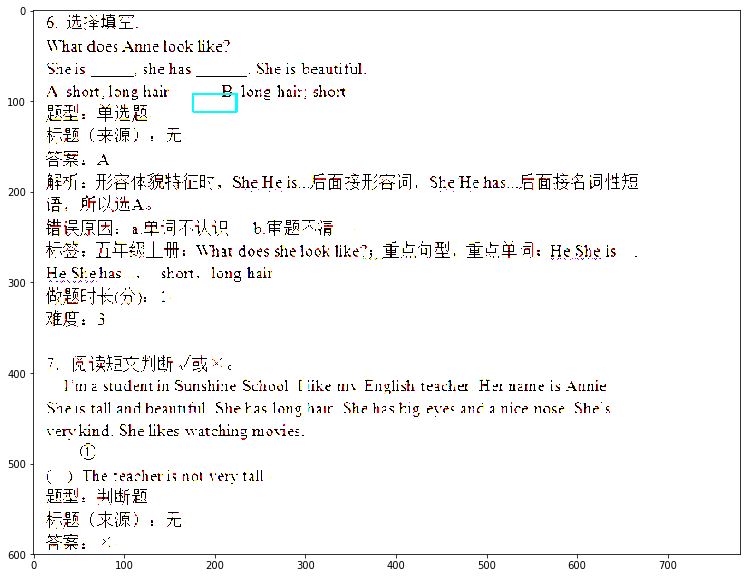

In [16]:
import lib.text_connector.text_proposal_connector as tpc
import lib.utils.nms as nms
import lib.layutils.proposal_layer as psl
import matplotlib.pyplot as plt
import cv2
import numpy as np
import importlib
importlib.reload(tpc)
importlib.reload(psl)
import time

DEBUG = True

def connect_proposal(text_proposals, scores, im_size):
    cp = tpc.TextProposalConnector()
    line = cp.get_text_lines(text_proposals, scores, im_size)
    return line


def save_results(image_name, im, line, thresh):
    inds = np.where(line[:, -1] >= thresh)[0]
#     print('inds --->{}'.format(len(inds)))
    if len(inds) == 0:
        return
    
    for i in inds:
        bbox = line[i, :]
#         print('bbox {}--> \n {}'.format(i,bbox))
        score = line[i, -1]
        cv2.rectangle(
            im, (bbox[0], bbox[1]), (bbox[6], bbox[7]),
            color=(0, 255, 255),
            thickness=2)
    plt.imshow(im,'brg')
    plt.show()
    cv2.imwrite('d:\\1.jpg',im)
    
def testConnectProposal():
    plt.rcParams['figure.figsize'] = 15, 10
    img = cv2.imread(roidb[1]['image'])
    boxes = roidb[1]['boxes']
    scores = np.ones(boxes.shape[0])
    CONF_THRESH = 0.9
    NMS_THRESH = 0.3
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32)
    keep = nms.nms(dets, NMS_THRESH)
    dets = dets[keep,:]
    line = connect_proposal(dets[:, 0:4], dets[:, 4], img.shape)
    line = line.astype(int)
    save_results("newimg.jpg", img, line, thresh=0.7)

def validNet():
    feat_stride = [16, ]
    ANCHOR_SCALES = [16]
    ANCHOR_RATIOS = [0.5,1,2]
    num_anchors = 10

    blobs = data_layer.forward()
    
    image = blobs['data']
    image_src = image.copy()
    im_info = blobs['im_info']
    
    image = torch.from_numpy(blobs['data'].transpose([0,3,1,2]))
    net.eval()
    net_conv = net._layers['head'](image)
    anchors, length = generate_anchors_pre(net_conv.size(2), net_conv.size(3),feat_stride=feat_stride,anchor_scales=(16,))
    anchors = torch.from_numpy(anchors)
    rpn = F.relu(net.rpn_net(net_conv))
    rpn_reshape = rpn.permute(0,2,3,1).squeeze(0)
    rpn_blstm,_ = net.rpn_bi_net(rpn_reshape)
    rpn_blstm = F.relu(rpn_blstm) 
    rpn_cls_score,_ = net.rpn_cls_score_net(rpn_blstm)
    rpn_cls_score = rpn_cls_score.permute(2,0,1).unsqueeze(0)
    rpn_cls_score_reshape = rpn_cls_score.contiguous().view(1,2,-1,rpn_cls_score.size()[3]) 
    rpn_cls_score = rpn_cls_score.permute(0,2,3,1)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape,dim=1)  
    
    if DEBUG:
        print('rpn cls score size --> {}'.format(rpn_cls_score.size()))
        print('rpn cls prob reshape size --> {}'.format(rpn_cls_score_reshape.size()))
        
    rpn_cls_prob = rpn_cls_prob_reshape.view(1,2*10,-1,rpn_cls_prob_reshape.shape[-1])  # N,2,num_anch*h, w --> N, 2*num_anchor h w
    if DEBUG:
        print('rpn cls prob size -->{}'.format(rpn_cls_prob.size()))
    
    rpn_cls_prob = rpn_cls_prob.permute(0,2,3,1)
    
    if DEBUG:
        print('rpn cls prob size -->{}'.format(rpn_cls_prob.size()))    
        
    rpn_cls_pred = rpn_cls_score_reshape.permute(0,2,3,1).contiguous()
    if DEBUG:
        print('rpn cls pred size -->{}'.format(rpn_cls_pred.size()))    
    
    rpn_cls_pred = torch.max(rpn_cls_pred.view(-1,2),1)[1]
    rpn_bbox_pred,_ = net.rpn_bbox_pred_net(rpn_blstm) 
    rpn_bbox_pred = rpn_bbox_pred.unsqueeze(0)
    
    blob, scores = psl.proposal_layer(rpn_cls_prob, 
                                      rpn_bbox_pred.contiguous(),
                                      im_info,
                                      'TEST',
                                      feat_stride,
                                      anchors,
                                      num_anchors)
    return image_src, blob, scores

def showValidNet():
    start_time = time.time()
    with torch.no_grad():
        image_src, blob, scores = validNet()
    print('handle times {:.4f}'.format((time.time() - start_time)))  
    plt.rcParams['figure.figsize'] = 15, 10
    boxes = blob.data.numpy()[:,1:5]
    score = scores.data.numpy()
    score = score.reshape(score.shape[0])
#     print('score --> \n {}'.format(score))
    image_new = image_src.reshape(image_src.shape[1],image_src.shape[2], image_src.shape[3])

    dets = np.hstack((boxes, score[:, np.newaxis])).astype(np.float32)
    keep = nms.nms(dets, 0.3)
    dets = dets[keep,:]
    print('dets --> \n {}'.format(dets))
    line = connect_proposal(dets[:, 0:4], dets[:, 4], image_new.shape)
    line = line.astype(int)
#     print(line)
    # image_new = image_src.reshape(image_src.shape[1],image_src.shape[2], image_src.shape[3])
    print(line[0:1])
    save_results('newimg.jpg',image_new, line[0:1], 0)    
    
showValidNet()


In [13]:
print(score)

NameError: name 'score' is not defined